In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.cross_validation import train_test_split,cross_val_predict,cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso, Ridge
from sklearn.svm import SVR,SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.decomposition import PCA


# Load the Data

In [76]:
games_avg = pd.read_csv('../Data/CSV_files/games_avg_final02')
del games_avg['Unnamed: 0']
print games_avg.shape

(4174, 117)


In [77]:
#games_avg

In [78]:
games_avg = games_avg[:-1]

In [79]:
features = games_avg[[x for x in games_avg.columns if x not in ['GameTime','GameDate','host_shortname','GameId',
                                                                'HostScore','GuestScore','score_diff',
                                                                'gq3','gq4','got1','got2','got3','got4',
                                                                'hq3','hq4','hot1','hot2','hot3','hot4',
                                                                'gq1','gq2',
                                                                'hq1','hq2',
                                                                #'HostName','GuestName',
                                                                #'game_line','total_line'
                                                                     ]]]

print features.shape
features = pd.get_dummies(features)
print features.shape

features.head(1)

(4173, 114)
(4173, 230)


,Season,total_score,total_line,game_line,Host_HostRank,Host_GameRank,Guest_GuestRank,Guest_GameRank,Headsup_GameRank_Season,Headsup_GameRank_All,...,loser_Oklahoma City Thunder,loser_Orlando Magic,loser_Philadelphia 76ers,loser_Phoenix Suns,loser_Portland Trail Blazers,loser_Sacramento Kings,loser_San Antonio Spurs,loser_Toronto Raptors,loser_Utah Jazz,loser_Washington Wizards
0,2013,227.0,207.5,7.5,13,21,13,22,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Selecting Predictors and Train-Test Data Sets

### Use LinearRegression to store coefs

In [80]:
y = features.total_score
X = features[[x for x in features.columns if x != 'total_score']]#StandardScaler().fit_transform(features)

scores = []
predictions = []
coefs = []
for i in range(1000) :    
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    scores.append(lr.score(X_test,y_test))
    predictions.append(np.mean(np.abs(lr.predict(X_test) - y_test)))
    coefs.append(lr.coef_)
np.mean(scores), np.std(predictions), np.mean(predictions)

(0.20577320321775222, 0.6083806744090513, 13.496103478027102)

### Find The Coefficents and Select features based on most 10% values of coefs

In [81]:
coef_df = pd.DataFrame(coefs,columns=[x for x in features.columns if x != 'total_score'])

coef_df = coef_df.applymap(lambda x: 1 if x >= 0 else 0)
coef_sum = coef_df.sum(0)
coef_effect = pd.DataFrame(coef_sum,columns=['count_positive']).reset_index()
coef_list = coef_effect[(coef_effect.count_positive > 900) | (coef_effect.count_positive <100)]['index']
#games_avg[coef_list]

In [113]:
coef_print = pd.DataFrame(coefs,columns=[x for x in features.columns if x != 'total_score']).mean()
coef_final = pd.DataFrame(coef_print,columns=['coef']).reset_index()
coef_final['abs_coef'] = coef_final.coef.apply(np.abs)
coef_final.sort_values('abs_coef',ascending=False,inplace=True)
coef_final = coef_final.head(23)
coef_final

,index,coef,abs_coef
11,host_win_count,4.524102e+11,4.524102e+11
4,Host_GameRank,-3.084953e+11,3.084953e+11
15,game_behind,-2.878297e+11,2.878297e+11
14,guest_lose_count,2.633732e+11,2.633732e+11
30,hFG_avg10,2.288488e+11,2.288488e+11
67,gFG_avg10,-2.125803e+11,2.125803e+11
12,host_lose_count,1.645804e+11,1.645804e+11
6,Guest_GameRank,-1.194583e+11,1.194583e+11
47,hPTS_avg10,-1.144244e+11,1.144244e+11
33,h3P_avg10,1.144244e+11,1.144244e+11


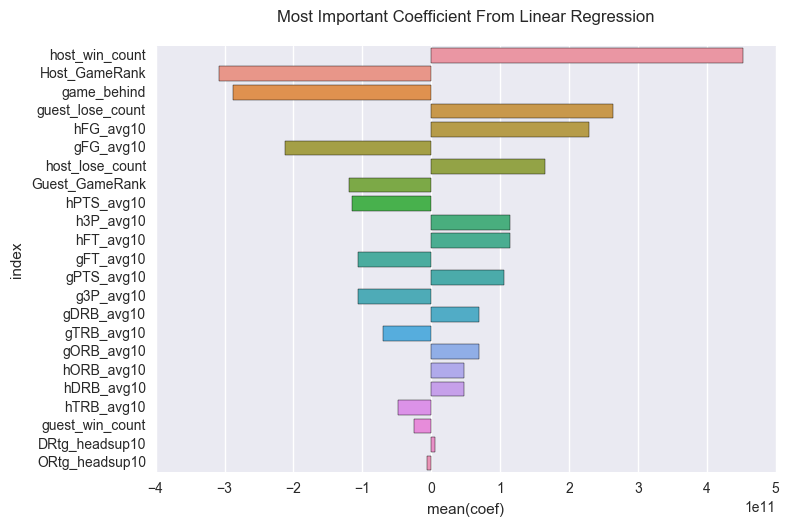

In [123]:
sns.barplot(y= 'index',x= 'coef',data= coef_final)
plt.title('Most Important Coefficient From Linear Regression\n')
plt.savefig('../Pictures/coef.png', bbox_inches='tight')

plt.show()

### Re-Run The Linear Regression with Most Important features

In [14]:
X = games_avg[coef_list]

scores = []
predictions = []
coefs = []
for i in range(1000) :    
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
    lr = LinearRegression()
    #lr = Ridge()
    lr.fit(X_train,y_train)

    scores.append(lr.score(X_test,y_test))
    predictions.append(np.mean(np.abs(lr.predict(X_test) - y_test)))
    coefs.append(lr.coef_)
np.mean(scores), np.std(scores), np.mean(predictions)

(0.26194506937645429, 0.017121502836787539, 12.967638458471161)

## Gread Search for Random forest

# Use Previous Seasons Data to predict the last Season With Random Forest

In [15]:
predicts = []
scores = []

coef_list_final = list(coef_list)
coef_list_final.append('total_score')
#list(coef_list)

features_train = features[features.Season.isin([2013,2014,2015,2016])]#[coef_list_final]
features_test = features[features.Season.isin([2017])]#[coef_list_final]

X_train = features_train[[x for x in features_train.columns if x != 'total_score']]
y_train = features_train.total_score
X_test = features_test[[x for x in features_test.columns if x != 'total_score']]
y_test = features_test.total_score

model = RandomForestRegressor(min_samples_split=16,max_features=None,max_depth=None,n_estimators=1500)
#model = Ridge(alpha=1980)
#model = RandomForestRegressor(min_samples_split=16,max_features=25,max_depth=16,n_estimators=1500)
#model = GradientBoostingRegressor(n_estimators=500,min_samples_split=16,learning_rate=0.01)
#model = AdaBoostRegressor()
#model = LinearRegression()

model.fit(X_train,y_train)
predicts = model.predict(X_test)
scores = model.score(X_test,y_test)


In [18]:
mydata = pd.DataFrame(X_test, columns=features.columns)
mydata['y_true'] = y_test
mydata['y_hat'] = predicts

team_names = games_avg[['HostName','GuestName']] #,'HostScore','GuestScore'
mydata = mydata.merge(team_names,left_index=True,right_index=True,suffixes=('',''))

mydata['myerror'] = np.abs(mydata.y_hat - mydata.y_true)
mydata['beterror'] = np.abs(mydata.total_line - mydata.y_true)
mydata['errordiff'] = np.abs(mydata.y_hat - mydata.total_line)

def confusion_metrix(row) :
    
    if row['y_hat'] >= row['total_line'] :
        if row['y_true'] > row['total_line'] :
            row['true_over']  = 1
            row['false_over'] = 0
            row['true_under'] = 0
            row['false_under']= 0
        else :
            row['true_over']  = 0
            row['false_over'] = 1
            row['true_under'] = 0
            row['false_under']= 0

    if row['y_hat'] < row['total_line'] :
        if row['y_true'] < row['total_line'] :
            row['true_over']  = 0
            row['false_over'] = 0
            row['true_under'] = 1
            row['false_under']= 0
        else :
            row['true_over']  = 0
            row['false_over'] = 0
            row['true_under'] = 0
            row['false_under']= 1    
    return row

mydata = mydata.apply(confusion_metrix,axis=1)
        
def ifIWon(row) :
    if (row['y_true'] > row['total_line']) & (row['y_hat'] > row['total_line']) :
        row['win_total_line'] = 1
    elif (row['y_true'] < row['total_line']) & (row['y_hat'] < row['total_line']) :
        row['win_total_line'] = 1
    elif row['y_true'] == row['total_line'] :
        row['win_total_line'] = 0
    else :
        row['win_total_line'] = -1
    return row

mydata = mydata.apply(ifIWon, axis = 1)

def baseline(row) :
    if (row['y_true'] > row['total_line'])  :
        row['over_under'] = 1
    elif  (row['y_true'] == row['total_line']):
        row['over_under'] = 0
    else :
        row['over_under'] = -1
    return row

mydata = mydata.apply(baseline, axis = 1)

def my_over_under(row) :
    if (row['y_hat'] >= row['total_line'])  :
        row['my_over_under'] = 1
    else :
        row['my_over_under'] = 0
    return row

mydata = mydata.apply(my_over_under, axis = 1)


errordata = mydata[['Season','GuestName','HostName','y_true','total_line',
                    'y_hat','myerror','beterror','errordiff','over_under','my_over_under',
                    'win_total_line','true_over','true_under','false_over','false_under',
                    'Host_HostRank','Host_GameRank','Guest_GuestRank','Guest_GameRank',
                    'game_line','Headsup_GameRank_Season','Headsup_GameRank_All',
                    'Host_LastGameDiff','Guest_LastGameDiff','host_win_count','host_lose_count',
                    'guest_win_count','guest_lose_count','game_behind','host_strike','guest_strike',
                    'host_place_streak','guest_place_streak'
                   ]]


wheniwin = errordata[errordata.win_total_line == 1]
wheniloose = errordata[errordata.win_total_line == -1]
whenidraw = errordata[errordata.win_total_line == 0]


error_margin = 13
differrormargin = 2

bigesterrors = errordata[errordata.myerror > error_margin]
smallestsrrors = errordata[errordata.myerror <=error_margin]
closesterrors = errordata[errordata.errordiff <=differrormargin]
faresterrors = errordata[errordata.myerror > differrormargin]

print 'Train Data Shape:',X_train.shape
print 'Test Data Shape:',X_test.shape,
print 'Whole Data Shape' ,features.shape
print '---------------------------------'
print 'Regression Model score:', scores
print 'Mean Absolute Error:', errordata.myerror.mean()
print 'Bet Line Mean Absolute Error of All Games:', errordata.beterror.mean()
print '----------------------------------------'
print 'Baseline:'
print 'Total Count/Percent Of Actual Over:(Base Line)',mydata.over_under[mydata.over_under == 1].count(),'--',100.*mydata.over_under[mydata.over_under == 1].count()/mydata.over_under.count()
print 'Total Count/Percent Of Actual Under:(Base Line)',mydata.over_under[mydata.over_under == -1].count(),'--',100.*mydata.over_under[mydata.over_under == -1].count()/mydata.over_under.count()
print 'Total Count/Percent Of Actual Tie:(Base Line)',mydata.over_under[mydata.over_under == 0].count(),'--',100.*mydata.over_under[mydata.over_under == 0].count()/mydata.over_under.count()
print '----------------------------------------'
print 'Confussion Metrix:'
print 'True Over:',mydata.true_over.sum(),'False Over:',mydata.false_over.sum()
print 'False Under:',mydata.false_under.sum(),'True Under:',mydata.true_under.sum()
print 
print 'Total Predicted Over:',mydata.true_over.sum()+mydata.false_over.sum(),
print '-- Over Accuracy:',100.*mydata.true_over.sum()/(mydata.true_over.sum() + mydata.false_over.sum())
print 'Total Predicted Under:',mydata.true_under.sum()+mydata.false_under.sum(),
print '-- Under Accuracy:',100.*mydata.true_under.sum()/(mydata.true_under.sum() + mydata.false_under.sum())
print '****************************************'
print '****************************************'
print 'Number and percent of games that i win::',errordata[errordata.win_total_line == 1]['win_total_line'].count(),' -- ',
print 100.0*errordata[errordata.win_total_line == 1]['win_total_line'].count() /errordata.win_total_line.count() 

print 'Number and percent of games that i lose:',errordata[errordata.win_total_line == -1]['win_total_line'].count(),' -- ',
print 100.0*errordata[errordata.win_total_line == -1]['win_total_line'].count() /errordata.win_total_line.count() 

print 'Number and percent of games that i draw:',errordata[errordata.win_total_line == 0]['win_total_line'].count(),' -- ',
print 100.0*errordata[errordata.win_total_line == 0]['win_total_line'].count() /errordata.win_total_line.count() 

print 'percent of pure win with bet on over/under:',100*(wheniwin.shape[0] - 1.1*wheniloose.shape[0])/X_test.shape[0],'%'
print '****************************************'
print '****************************************'
print
print '% of win, When i predict bad:',100.0*bigesterrors[bigesterrors.win_total_line == 1]['win_total_line'].sum() /bigesterrors.win_total_line.count() 
print 'Mean Residials :',bigesterrors.myerror.mean()
print 'Bet Mean Residials :',bigesterrors.beterror.mean()
print 'number of bad predicted games:',bigesterrors.shape[0]
print '---------------------------------'
print '% of win, When i predict good:',100.0*smallestsrrors[smallestsrrors.win_total_line == 1]['win_total_line'].sum() /smallestsrrors.win_total_line.count() 
print 'Mean Residials :',smallestsrrors.myerror.mean()
print 'Bet Mean Residials :',smallestsrrors.beterror.mean() 
print 'number of good predicted games:', smallestsrrors.shape[0] 
print '---------------------------------'
print '---------------------------------'
print '% of win, When i predict close to the line:',100.0*closesterrors[closesterrors.win_total_line == 1]['win_total_line'].sum() /closesterrors.win_total_line.count() 
print 'Mean Residials :',closesterrors.myerror.mean()
print 'Bet Mean Residials :',closesterrors.beterror.mean()
print 'number of bad predicted games:',closesterrors.shape[0]
print '----------------------------------'
print '% of win, When i predict far from the line:',100.0*faresterrors[faresterrors.win_total_line == 1]['win_total_line'].sum() /faresterrors.win_total_line.count() 
print 'Mean Residials :',faresterrors.myerror.mean()
print 'Bet Mean Residials :',faresterrors.beterror.mean() 
print 'number of good predicted games:', faresterrors.shape[0] 

errordata.to_csv('../Data/CSV_files/error_data')

Train Data Shape: (3768, 229)
Test Data Shape: (405, 229) Whole Data Shape (4173, 230)
---------------------------------
Regression Model score: 0.165478430941
Mean Absolute Error: 13.1895953102
Bet Line Mean Absolute Error of All Games: 12.9148148148
----------------------------------------
Baseline:
Total Count/Percent Of Actual Over:(Base Line) 193 -- 47.6543209877
Total Count/Percent Of Actual Under:(Base Line) 206 -- 50.8641975309
Total Count/Percent Of Actual Tie:(Base Line) 6 -- 1.48148148148
----------------------------------------
Confussion Metrix:
True Over: 54 False Over: 44
False Under: 144 True Under: 163

Total Predicted Over: 98 -- Over Accuracy: 55.1020408163
Total Predicted Under: 307 -- Under Accuracy: 53.0944625407
****************************************
****************************************
Number and percent of games that i win:: 217  --  53.5802469136
Number and percent of games that i lose: 182  --  44.9382716049
Number and percent of games that i draw: 6  -

In [162]:
model_coef = pd.DataFrame(pd.DataFrame(model.feature_importances_).T)
model_coef.columns = X_train.columns
model_coef = model_coef.T.reset_index()
model_coef.columns = ['title','value']
model_coef = model_coef.sort_values('value',ascending=False).head(23)

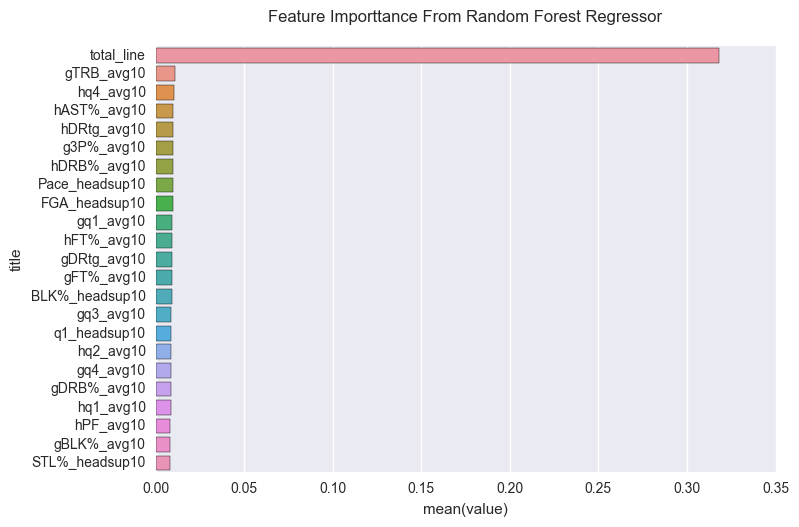

In [164]:
sns.barplot(y= 'title',x= 'value',data= model_coef)
plt.title('Feature Importtance From Random Forest Regressor\n')
plt.savefig('../Pictures/featureimportance.png', bbox_inches='tight')

plt.show()

In [163]:
model_coef

,title,value
1,total_line,0.318146
78,gTRB_avg10,0.011059
23,hq4_avg10,0.010183
53,hAST%_avg10,0.010066
56,hDRtg_avg10,0.010051
72,g3P%_avg10,0.009951
51,hDRB%_avg10,0.009909
98,Pace_headsup10,0.009872
100,FGA_headsup10,0.009785
57,gq1_avg10,0.009524


# Try to Find the Games that i'm so off

In [1429]:
temp_X_test = X_test
temp_X_test['y_hat'] = predicts
temp_X_test['y_true'] = y_test
temp_X_test['myerror'] = np.abs(temp_X_test['y_hat'] - temp_X_test['y_true'])
temp_X_test['is_bad'] = temp_X_test.myerror.apply(lambda x : 1 if x > 15 else 0)

ValueError: Length of values does not match length of index

In [1409]:
new_X_train = X_test
new_y_train = temp_X_test.is_bad
new_X_test = X_train
#new_y_test = y_train

In [1417]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 2783 to 3767
Columns: 233 entries, Season to myerror
dtypes: float64(217), int64(16)
memory usage: 1.8 MB


In [1414]:
new_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2783 entries, 0 to 2782
Columns: 229 entries, Season to loser_Washington Wizards
dtypes: float64(214), int64(15)
memory usage: 4.9 MB


In [1416]:
print X_test.shape,new_X_train.shape, new_y_train.shape,new_X_test.shape

(985, 233) (985, 233) (985,) (2783, 229)


# ROAD MAP

### Feature Engineering 
- Create differenet Avg columns
- Create Agg columns for heads-up matches
- Create features for distance traveled/time zone change
- Add Game Time to recovery time

Test which average lengths work best in the model. Try out exponentially weighted moving average. Test different decay strengths. Maybe write your own "grid search" over decay strengths: for a decay automatically make the averaged variables and then build, test a model. Record the performance of each one.

Put host and opponent columns back in to test with random forest (interactions may be important, even if main effects were not). You can check/validate by looking at feature importances.


### Model Improvement
- Create model for predicting high risk games based on Mean Absolute Error



### Model Execution And Prediction 
- Develop Application to scrape last day match/bet results
- Develop Application to input next game and give back the prediction 

https://github.com/ipython/ipywidgets
https://demo.bokehplots.com/


### Leaning Porpuses
- Put my data and model in AWS


### Questions
- Which Fundumental Concepts could be usefull for my model improvment? 
- - PCA
- - Bootstapping
- - Bagging & Boosting
- - T-Test
- - Bayesian Statistics
- - ???
- Do you want to invest on my model? :-D


RDS for database or EC2,doccer in easier

EC2 instance, lubanto in the first 4 amazon images, 

EMR cluster, in spark 
upload my csv to master, zipplin or pyspark
SCP utility,takes and source destination
spark.read

## OLD Kiefer Notes :
Training data:

Currently:
y_true = total score of the game
your model is predicting the total score

You can also have a second target:
y_diff = error_diff 
Predict y_diff from your features - the same features you used to predict y_true
Split training data into 2 halves, make error_diff for each with model built on the other

Also try random forest

parameters to gridsearch for RandomForestRegressor:

```python
params = {
    'n_estimators':[1000],
    'criterion':['mae'],
    'max_depth':[2,3,5,7,None],
    'min_samples_split':[2,4,8,16,32,64,128],
    'max_features':[None, 'sqrt', 'log2']
    }

```

# Other Models

In [938]:
rf_predicts = []
rf_scores = []

params = {
    'n_estimators':[1500,1000],
    'criterion':['mse'],
    'max_depth':[2,16,None],
    'min_samples_split':[2,8,16],
    'max_features':[None, 'sqrt',25]
    }

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

rf = RandomForestRegressor()

estimator = GridSearchCV(rf, params, cv= 4, verbose= 1)

estimator.fit(X_train,y_train)

rf_predicts = estimator.predict(X_test)
rf_scores = estimator.score(X_test,y_test)

print rf_scores, np.mean(rf_scores)
print estimator.best_params_
print np.mean(np.abs(estimator.predict(X_test) - y_test))

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 10.0min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 134.6min
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 152.8min finished


In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

In [44]:
params = {
    'alpha' : np.arange(0, 1, 0.01)
    
}



lasso = Lasso()

estimator = GridSearchCV(lasso,param_grid=params,cv=10)
estimator.fit(X_train,y_train)

predictions = estimator.predict(X_test)

print estimator.score(X_test,y_test)
print np.mean(np.abs(predictions - y_test))

/Users/behdad/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/behdad/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/behdad/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


0.646942785319
8.55690771843


In [54]:
params = {
    'alpha' : np.arange(200, 10000, 50)
    
}



ridge = Ridge()

estimator = GridSearchCV(ridge,param_grid=params,cv=5)
estimator.fit(X_train,y_train)

predictions = estimator.predict(X_test)

print estimator.score(X_test,y_test)
print np.mean(np.abs(predictions - y_test))

0.854026618022
8.54883865101


In [55]:
estimator.best_params_

{'alpha': 200}

In [57]:
dtr = DecisionTreeRegressor()

dtr.fit(X_train,y_train)

predictions = dtr.predict(X_test)

print dtr.score(X_test,y_test)
print np.mean(np.abs(predictions - y_test))

0.554890215212
14.8290748899


In [60]:
svr = SVR()

svr.fit(X_train,y_train)

predictions = svr.predict(X_test)

print svr.score(X_test,y_test)
print np.mean(np.abs(predictions - y_test))

0.214871131454
13.899822307


In [66]:
games_pca = PCA()
games_pca.fit(X)
games_pcs = games_pca.transform(X)

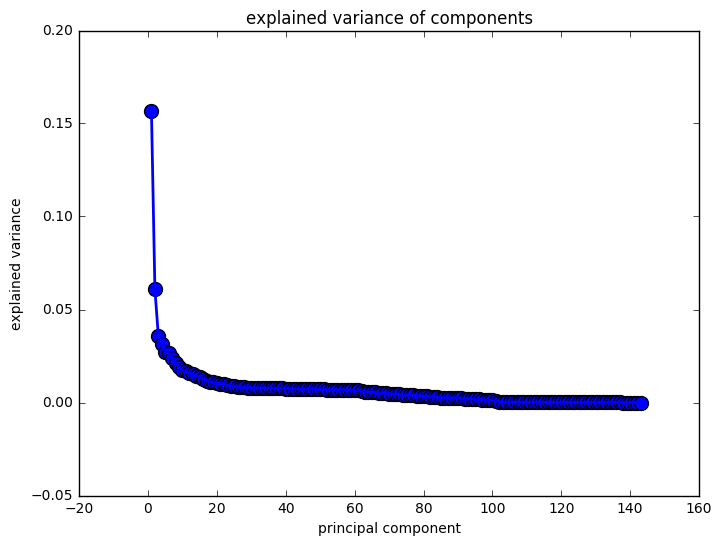

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, X.shape[1]+1), games_pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, X.shape[1]+1), games_pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [68]:
games_pca.components_

array([[  3.53257204e-02,   1.08622119e-01,   1.08891573e-01, ...,
         -9.91182918e-04,  -2.81420112e-03,  -4.10096432e-03],
       [ -5.11770633e-02,   1.26781110e-02,  -1.09319381e-02, ...,
         -1.38865297e-02,   4.92336255e-02,   9.83173486e-03],
       [  1.73763427e-02,  -2.06112755e-02,  -3.17114763e-02, ...,
         -5.11786209e-02,  -5.28372291e-03,   5.87892375e-02],
       ..., 
       [ -1.11287417e-13,  -9.24534955e-14,  -3.32820996e-14, ...,
          5.98222469e-06,   5.68012485e-06,   5.95771935e-06],
       [ -2.24448110e-16,  -7.20267868e-17,  -1.41490210e-16, ...,
          1.46840896e-01,   1.39425488e-01,   1.46239378e-01],
       [  0.00000000e+00,   3.97465975e-17,   1.41487571e-17, ...,
          1.12711569e-01,   1.07019678e-01,   1.12249857e-01]])

In [72]:
games_pcs.shape

(3439, 30)

In [70]:
X.shape

(3439, 143)

In [71]:
games_pcs = pd.DataFrame(games_pcs)
games_pcs = games_pcs.iloc[:,:30]

In [210]:
games_pcs

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.982755,-4.115200,1.406928,-3.757984,3.656259,1.613922,-1.890569,-2.622225,-2.661984,2.518709,...,-0.738718,-0.023524,-0.969870,-0.562183,-1.216451,1.134578,-0.182661,-2.046463,-1.864370,0.570880
1,3.607682,7.496757,3.454382,5.037950,-0.579141,-0.176741,0.166539,0.840192,0.313012,1.047595,...,0.918762,-0.638830,1.385301,-0.052956,-0.145171,1.455080,1.075812,0.482158,1.494449,-1.311899
2,3.997884,-3.165365,-4.122333,-1.276138,0.118351,-2.938084,2.389109,-0.843803,-1.732838,-4.986368,...,-2.204822,0.755812,-0.722123,-1.416533,0.679098,1.199353,1.478558,-0.986917,-0.521556,-0.736711
3,5.748678,-1.478169,-0.594992,-4.158985,2.174499,-0.259768,2.037785,0.962816,-0.378658,1.723109,...,-1.596054,0.155321,-1.061750,2.784604,-2.075540,0.969271,-1.007516,-1.041927,-0.408836,-0.179374
4,8.887310,-5.232141,2.010836,1.554207,-0.550797,3.529540,5.317237,0.790587,-0.670597,-2.453734,...,-3.607736,0.351768,0.106923,-2.728456,-0.613580,-0.222306,1.070596,0.956270,-0.864357,-0.182315
5,3.572635,0.986207,2.006660,-1.515516,-1.117444,-2.525403,6.439270,0.794542,1.419729,0.457019,...,-1.113163,-3.563197,-0.602929,-1.062612,-1.118831,-0.488971,0.149708,0.157637,-0.749770,-1.297730
6,4.259470,0.098404,-0.458336,1.818204,-1.858724,-3.302179,-0.893786,-0.698713,-3.780284,2.449144,...,-0.878282,0.947494,-1.596418,1.719465,0.658379,-0.670800,-2.189380,0.263769,1.024148,-0.888278
7,-3.839558,3.130066,0.852576,0.694067,-3.162966,-4.763087,1.578844,0.565021,3.119084,-4.506019,...,-2.034292,-0.095932,-2.281433,1.199133,-0.307719,-0.223515,-0.735623,-0.330136,-1.119633,-1.172055
8,5.849369,-0.710844,-0.011611,2.792113,5.369946,2.842351,2.248036,3.087862,2.111505,-4.127600,...,2.397921,0.228280,-0.146146,0.482149,0.261895,1.823439,-0.922943,1.771317,-0.703432,-0.097629
9,-5.319738,2.343567,1.054355,5.043071,1.911188,-6.283395,-0.080140,1.584919,4.934165,3.112176,...,-0.760758,0.586755,0.508197,0.411074,1.018920,-1.094989,0.500371,-0.442784,0.931434,-1.870566


# DB SCAN

In [1295]:
mytarget.shape

(405, 245)

In [1264]:
#dbscan_data.info()

In [1275]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [1276]:
db = DBSCAN(eps=0.5, min_samples=5,metric='euclidean', algorithm='auto', leaf_size=5, p=None, random_state=None)
db_result = db.fit_predict(dbscan_data)

In [1277]:
pd.Series(db_result).value_counts()

-1    405
dtype: int64

In [1278]:
km = KMeans(2)
Kmean_result = km.fit_predict(dbscan_data)

In [1279]:
pd.Series(Kmean_result).value_counts()

1    203
0    202
dtype: int64

In [1289]:
km.score(dbscan_data,mytarget.bad_games)

-533728.97191757243

In [1292]:
mytarget.bad_games.shape, Kmean_result.shape

((406,), (405,))

In [1302]:
correct = 0

for x,y in zip(mytarget.bad_games.values, Kmean_result):
    if x == y:
        correct += 1
        

In [1317]:
dbscan_data = mydata[[x for x in mydata.columns if not x in ['total_score','y_true','GuestName','HostName','winner','loser']]][:-1]

In [1318]:
mydata['bad_games'] = mydata.myerror.apply(lambda x: 1 if x > 13 else 0)
mytarget = mydata['bad_games'][:-1]

In [1319]:
print dbscan_data.shape,mytarget.shape

(405, 241) (405,)


In [1322]:
[x for x in dbscan_data.columns]

['Season',
 'total_line',
 'game_line',
 'Host_HostRank',
 'Host_GameRank',
 'Guest_GuestRank',
 'Guest_GameRank',
 'Headsup_GameRank_Season',
 'Headsup_GameRank_All',
 'Host_LastGameDiff',
 'Guest_LastGameDiff',
 'host_win_count',
 'host_lose_count',
 'guest_win_count',
 'guest_lose_count',
 'game_behind',
 'host_strike',
 'guest_strike',
 'host_place_streak',
 'guest_place_streak',
 'hq1_avg10',
 'hq2_avg10',
 'hq3_avg10',
 'hq4_avg10',
 'hPace_avg10',
 'heFG%_avg10',
 'hTOV%_avg10',
 'hORB%_avg10',
 'hFT/FGA_avg10',
 'hORtg_avg10',
 'hFG_avg10',
 'hFGA_avg10',
 'hFG%_avg10',
 'h3P_avg10',
 'h3PA_avg10',
 'h3P%_avg10',
 'hFT_avg10',
 'hFTA_avg10',
 'hFT%_avg10',
 'hORB_avg10',
 'hDRB_avg10',
 'hTRB_avg10',
 'hAST_avg10',
 'hSTL_avg10',
 'hBLK_avg10',
 'hTOV_avg10',
 'hPF_avg10',
 'hPTS_avg10',
 'hTS%_avg10',
 'h3PAR_avg10',
 'hFTr_avg10',
 'hDRB%_avg10',
 'hTRB%_avg10',
 'hAST%_avg10',
 'hSTL%_avg10',
 'hBLK%_avg10',
 'hDRtg_avg10',
 'gq1_avg10',
 'gq2_avg10',
 'gq3_avg10',
 'gq4_avg

In [1321]:
dbscan_data = dbscan_data.iloc[:,:-12]

In [1324]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(dbscan_data, mytarget, test_size=0.33)
print X_train.shape, y_train.shape
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
preds = []
preds = clf.predict(X_test)
clf.score(X_test, y_test)

(271, 229) (271,)


0.4925373134328358

In [1326]:
preds

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

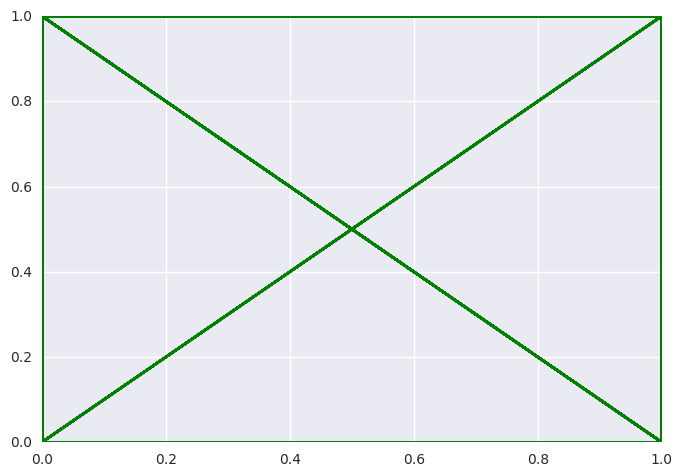

In [1300]:
plt.plot(mytarget.bad_games.values, Kmean_result, c="green")
plt.show()